# MID-SEMESTER EXAM 2024-2025
## Machine Learning
Neural Network (NN) Classification on Image Data

# Intro
In this mid-term exam, you are asked to classify facial images using the Casia-Webface dataset (Data can be downloaded on Kaggle). You are allowed to explore:

1. Pre-processing methods
2. Feature selection
3. ANN architecture
4. Activation function
5. Evaluation metrics

Kelompok :

1. Asti Nurin Hidayanti / 2241720236
2. Ellois Karina Handoyo / 2241720154
3. Mohammad Naufal Syahandra / 2241720189
4. Rio Bagas Hermawan / 2241720193

In [ ]:
import kagglehub
import numpy as np
import os
import shutil
import tensorflow as tf

# Pastikan dataset CASIA-Webface telah diunduh di direktori yang benar
path = kagglehub.dataset_download("ntl0601/casia-webface")

destination_path = "/content/casia-webface/"

# Cek jika direktori tujuan ada, jika tidak buatlah
if not os.path.exists(destination_path):
    os.makedirs(destination_path)

# Pindahkan semua file dari folder download ke folder sample_data
for filename in os.listdir(path):
    shutil.move(os.path.join(path, filename), os.path.join(destination_path, filename))

print("Path to dataset files:", destination_path)

100%|██████████| 2.53G/2.53G [00:10<00:00, 262MB/s]

Extracting files...


Path to dataset files: /content/casia-webface/


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from collections import Counter

def load_data(data_dir, target_size=(112, 112), min_images_per_person=200, max_images_per_person=200, max_persons=5000):
    data = []
    label_map = {}  # Untuk memetakan nama folder ke angka
    images_per_label = Counter()  # Untuk menghitung jumlah gambar per label

    # Mendapatkan semua folder (misalnya 00001, 00002, ...)
    person_folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

    # Memproses maksimal 2000 folder (orang)
    person_folders = person_folders[:max_persons]

    # Memproses setiap folder
    for idx, person in enumerate(person_folders):
        person_path = os.path.join(data_dir, person)
        img_files = [f for f in os.listdir(person_path) if f.endswith('.jpg')]

        # Jika jumlah gambar kurang dari min_images_per_person, abaikan folder tersebut
        if len(img_files) < min_images_per_person:
            continue

        img_count = 0  # Inisialisasi penghitung gambar per orang

        # Berikan nomor label berdasarkan urutan folder
        label_map[person] = idx

        # Memuat gambar dari folder tersebut
        for img_file in img_files[:max_images_per_person]:  # Ambil maksimal 50 gambar
            img_path = os.path.join(person_path, img_file)

            # Memuat gambar dan mengubah ukurannya
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = img_array / 255.0  # Normalisasi antara 0 dan 1

            # Gabungkan gambar dan label ke dalam satu array
            data.append((img_array, idx))  # idx adalah label yang sudah diubah jadi angka

            img_count += 1  # Tambah penghitung gambar
            images_per_label[idx] += 1  # Tambah penghitung jumlah gambar per label

            # Jika sudah mencapai max_images_per_person, berhenti mengambil gambar
            if img_count >= max_images_per_person:
                break

    # Mengonversi ke array NumPy (hanya bagian gambar)
    images_array = np.array([img for img, _ in data])
    labels_array = np.array([label for _, label in data])

    return images_array, labels_array, images_per_label

# Path ke dataset
data_directory = '/content/casia-webface/casia-webface'

images, labels, images_per_label = load_data(data_directory)

print("Shape of images array:", images.shape)
print("Shape of labels array:", labels.shape)

# Menampilkan jumlah data per label
for label, count in images_per_label.items():
    print(f"Label {label}: {count} images")


Shape of images array: (30000, 112, 112, 3)
Shape of labels array: (30000,)
Label 13: 200 images
Label 18: 200 images
Label 57: 200 images
Label 89: 200 images
Label 132: 200 images
Label 153: 200 images
Label 156: 200 images
Label 216: 200 images
Label 242: 200 images
Label 251: 200 images
Label 252: 200 images
Label 267: 200 images
Label 309: 200 images
Label 311: 200 images
Label 316: 200 images
Label 440: 200 images
Label 486: 200 images
Label 565: 200 images
Label 621: 200 images
Label 641: 200 images
Label 650: 200 images
Label 676: 200 images
Label 701: 200 images
Label 702: 200 images
Label 724: 200 images
Label 732: 200 images
Label 780: 200 images
Label 794: 200 images
Label 804: 200 images
Label 850: 200 images
Label 894: 200 images
Label 924: 200 images
Label 984: 200 images
Label 996: 200 images
Label 1083: 200 images
Label 1106: 200 images
Label 1108: 200 images
Label 1141: 200 images
Label 1161: 200 images
Label 1165: 200 images
Label 1212: 200 images
Label 1259: 200 ima

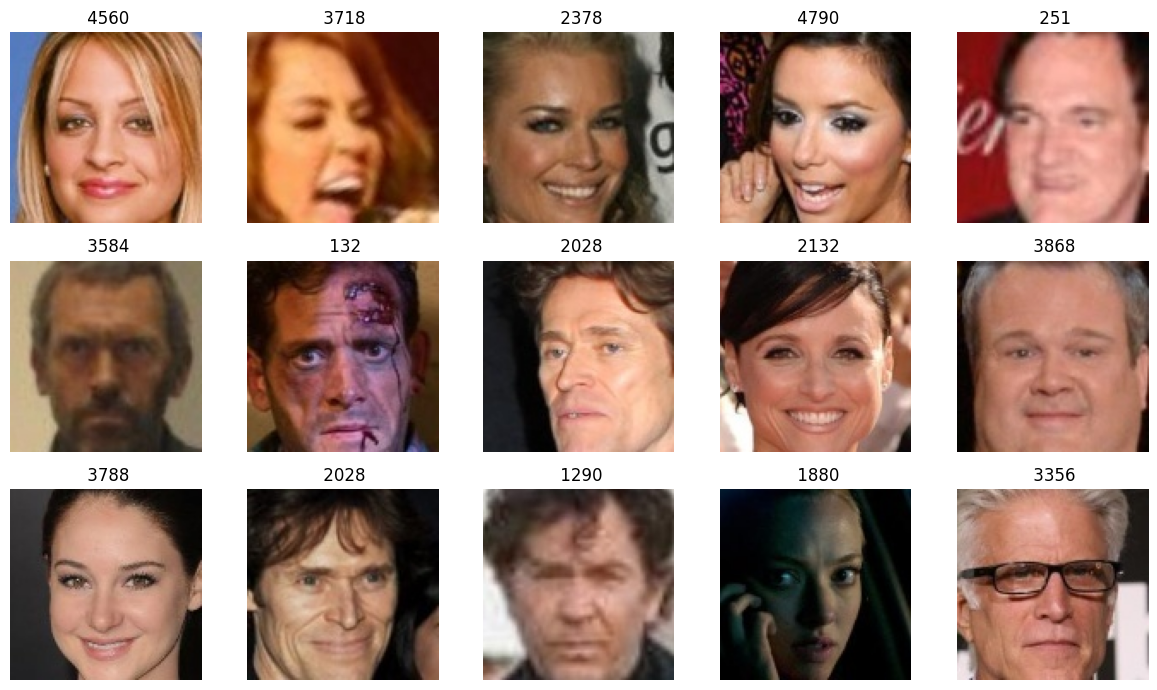

In [ ]:
from random import sample
import matplotlib.pyplot as plt

random_indices = sample(range(images.shape[0]), 15)

plt.figure(figsize=(12, 7))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[idx], cmap='bone')
    plt.title(f' {labels[idx]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("Jumlah Orang: ", len(np.unique(labels)))

Jumlah Orang:  150


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
for label, count in images_per_label.items():
    print(f"Label {label}: {count} images")

from sklearn.preprocessing import LabelEncoder

# Encode and convert labels to categorical
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
labels_categorical = to_categorical(labels_encoded, num_classes=num_classes)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

Label 13: 200 images
Label 18: 200 images
Label 57: 200 images
Label 89: 200 images
Label 132: 200 images
Label 153: 200 images
Label 156: 200 images
Label 216: 200 images
Label 242: 200 images
Label 251: 200 images
Label 252: 200 images
Label 267: 200 images
Label 309: 200 images
Label 311: 200 images
Label 316: 200 images
Label 440: 200 images
Label 486: 200 images
Label 565: 200 images
Label 621: 200 images
Label 641: 200 images
Label 650: 200 images
Label 676: 200 images
Label 701: 200 images
Label 702: 200 images
Label 724: 200 images
Label 732: 200 images
Label 780: 200 images
Label 794: 200 images
Label 804: 200 images
Label 850: 200 images
Label 894: 200 images
Label 924: 200 images
Label 984: 200 images
Label 996: 200 images
Label 1083: 200 images
Label 1106: 200 images
Label 1108: 200 images
Label 1141: 200 images
Label 1161: 200 images
Label 1165: 200 images
Label 1212: 200 images
Label 1259: 200 images
Label 1277: 200 images
Label 1285: 200 images
Label 1290: 200 images
Lab

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50
750/750 [==============================] - 65s 85ms/step - loss: 4.9877 - accuracy: 0.0095 - val_loss: 4.7603 - val_accuracy: 0.0318
Epoch 2/50
750/750 [==============================] - 60s 80ms/step - loss: 4.4155 - accuracy: 0.0588 - val_loss: 3.8028 - val_accuracy: 0.1625
Epoch 3/50
750/750 [==============================] - 59s 79ms/step - loss: 3.8386 - accuracy: 0.1328 - val_loss: 3.3581 - val_accuracy: 0.2507
Epoch 4/50
750/750 [==============================] - 59s 78ms/step - loss: 3.4477 - accuracy: 0.1934 - val_loss: 2.9623 - val_accuracy: 0.3542
Epoch 5/50
750/750 [==============================] - 60s 81ms/step - loss: 3.1825 - accuracy: 0.2447 - val_loss: 2.6819 - val_accuracy: 0.4115
Epoch 6/50
750/750 [==============================] - 61s 82ms/step - loss: 2.9640 - accuracy: 0.2838 - val_loss: 2.5092 - val_accuracy: 0.4630
Epoch 7/50
750/750 [==============================] - 63s 84ms/step - loss: 2.7918 - accuracy: 0.3216 - val_loss: 2.2557 - val_accuracy: